# Preparation

In [1]:
# Import primary functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
import sklearn
import catboost
import lightgbm
import xgboost
%matplotlib inline

# Import secondary functions
from prettytable import PrettyTable
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import tertiary functions
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Acquire the data

In [2]:
# Load the data directory
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

In [3]:
# Show first five rows of train dataset
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
# Show first five rows of test dataset
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [5]:
# Generate number of columns per dataset's table
print("Train data: ", train.shape)
print("Test data: ", test.shape)

Train data:  (90615, 10)
Test data:  (60411, 9)


In [8]:
# Generate the table description
target = 'Rings'

table = PrettyTable()

table.field_names = ['Column name', 'Data type', 'Train missing (%)', 'Test missing (%)']

for column in train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train = 100 - train[column].count() / train.shape[0] * 100
    
    if column != target:
        non_null_count_test = 100 - test[column].count() / test.shape[0] * 100
    else:
        non_null_count_test = "N/A"
    
    table.add_row([column, data_type, non_null_count_train, non_null_count_test])

print(table)

+----------------+-----------+-------------------+------------------+
|  Column name   | Data type | Train missing (%) | Test missing (%) |
+----------------+-----------+-------------------+------------------+
|       id       |   int64   |        0.0        |       0.0        |
|      Sex       |   object  |        0.0        |       0.0        |
|     Length     |  float64  |        0.0        |       0.0        |
|    Diameter    |  float64  |        0.0        |       0.0        |
|     Height     |  float64  |        0.0        |       0.0        |
|  Whole weight  |  float64  |        0.0        |       0.0        |
| Whole weight.1 |  float64  |        0.0        |       0.0        |
| Whole weight.2 |  float64  |        0.0        |       0.0        |
|  Shell weight  |  float64  |        0.0        |       0.0        |
|     Rings      |   int64   |        0.0        |       N/A        |
+----------------+-----------+-------------------+------------------+


# Visualize the data

<Axes: xlabel='Rings', ylabel='count'>

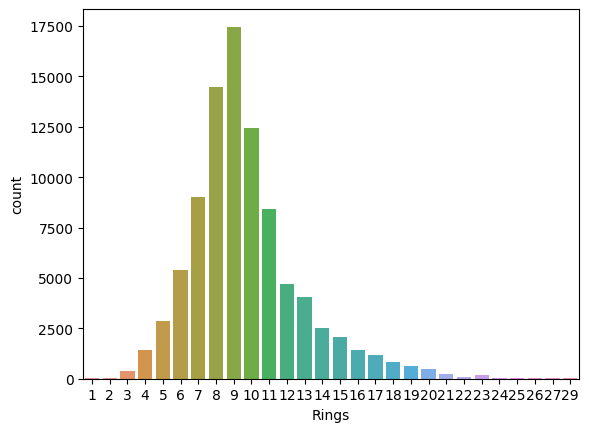

In [9]:
# Generate the bar chart
sns.countplot(x=target, data=train)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

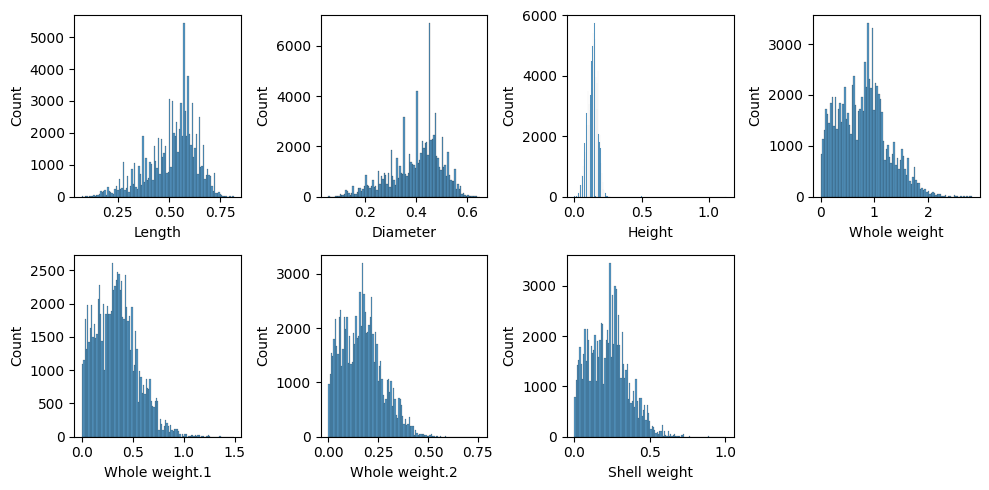

In [10]:
# Visualize the distribution of numerical variables
cols = train.drop(['id', 'Rings', 'Sex'], axis=1).columns

plt.figure(figsize=(10, 5))

for i, col in enumerate(cols):
    plt.subplot(2, 4, i + 1)
    sns.histplot(x=col, data=train)
    plt.tight_layout()

plt.show()

# Apply the model

In [20]:
train.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [21]:
my_cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'].copy()

X = train[my_cols]
y = train.Rings
X_test = test[my_cols].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [22]:
print("X train: ", X_train.shape)
print("X valid: ", X_valid.shape)

print("y train: ", y_train.shape)
print("y valid: ", y_valid.shape)

print("X test: ", X_test.shape)

X train:  (72492, 8)
X valid:  (18123, 8)
y train:  (72492,)
y valid:  (18123,)
X test:  (60411, 8)


In [23]:
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

numerical_transformer = SimpleImputer()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [24]:
model = RandomForestRegressor()

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [25]:
my_pipeline.fit(X_train, y_train)
my_pipeline.score(X_valid, y_valid)

0.6492354449586033

In [26]:
preds = my_pipeline.predict(X_valid)

preds

array([ 6.39,  7.12,  7.94, ..., 12.35,  6.55,  8.8 ])

In [27]:
predictions = my_pipeline.predict(X_test)

predictions

array([10.3 ,  9.7 ,  9.85, ..., 12.07, 13.31,  9.17])

# Generate a submission

In [30]:
output = pd.DataFrame({
    'id': test.id,
    'Rings': predictions
})

output.to_csv('submission.csv', index=False)
print("Successfully saved as CSV file")

Successfully saved as CSV file
